In [1]:
import numpy as np

In [2]:
# Refer to this link for implementation of subclassing ndarray
# https://numpy.org/doc/stable/user/basics.subclassing.html#slightly-more-realistic-example-attribute-added-to-existing-array

class adarray(np.ndarray):
    def __new__(cls, input_array, requires_grad=True):
        obj = np.asarray(input_array).view(cls)
        obj.requires_grad = requires_grad
        return obj

    def __array_finalize__(self, obj=None):
        if obj is None: return
        self.requires_grad = getattr(obj, "requires_grad", None)
        self.grad = np.zeros_like(self.__array__())
        
    def zero_grad(self):
        self.grad = np.zeros_like(self.__array__())

In [3]:
class NnOps:
    """
    Implements AD for certain neural network operations matmul, add, relu, sigmoid, mse, bce
    Each forward function has signature func(cls, w, x) where w is a static parameter like
    a parameter matrix or target values y, and x is the input from a previous operation.

    Forward operations record their inputs and function on the tape. During the backward()
    call, the backward function is computed for that given operation and its inputs.

    Backward operations update the gradient of w if w.requires_grad = True
    """
    tape = []
    eval = True
    
    @classmethod
    def matmul(cls, A, x):
        if not cls.eval:
            cls.tape.append((A, x, "matmul"))
        return A @ x
    
    @classmethod
    def add(cls, b, x):
        if not cls.eval:
            cls.tape.append((b, x, "add"))
        return b + x
    
    @classmethod
    def relu(cls, x):
        if not cls.eval:
            cls.tape.append((None, x, "relu"))
        return np.maximum(x, 0)
    
    @classmethod
    def sigmoid(cls, x):
        if not cls.eval:
            cls.tape.append((None, x, "sigmoid"))
        return 1 / (1 + np.exp(-x))
        
    @classmethod
    def mse(cls, y, y_hat):
        if not cls.eval:
            cls.tape.append((y, y_hat, "mse"))
        return 0.5 * np.sum((y - y_hat)**2)
    
    @classmethod
    def BinaryCrossEntropy(cls, y, y_hat):
        if not cls.eval:
            cls.tape.append((y, y_hat, "bce"))
        y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
        term_0 = (1-y) * np.log(1-y_hat + 1e-7)
        term_1 = y * np.log(y_hat + 1e-7)
        return -np.mean(term_0+term_1, axis=0)

    @staticmethod
    def _matmul_backward(A, x, delta_out):
        grad_A = np.outer(delta_out, x)
        delta_in = A.T @ delta_out
        if A.requires_grad:
            A.grad += grad_A
        return delta_in

    @staticmethod
    def _add_backward(b, x, delta_out):
        grad_b = np.ones_like(b) * delta_out
        delta_in = np.ones_like(x) * delta_out
        if b.requires_grad:
            b.grad += grad_b
        return delta_in
    
    @staticmethod
    def _relu_backward(x, delta_out):
        grad = np.ones_like(x)
        grad[x <= 0] = 0
        delta_in = grad * delta_out
        return delta_in

    @staticmethod
    def _sigmoid_backward(x, delta_out):
        sigma = 1 / (1 + np.exp(-x))
        delta_in = sigma * (1 - sigma) * delta_out
        return delta_in
    
    @staticmethod
    def _mse_backward(y, y_hat, delta_out=1):
        return delta_out * (y_hat - y)
    
    @staticmethod
    def _bce_backward(y, y_hat, delta_out=1):
        return delta_out * (y_hat - y)

    @classmethod
    def _op_backward(cls, w, x, op, delta_out):
        if op == "matmul":
            return cls._matmul_backward(w, x, delta_out)
        elif op == "add":
            return cls._add_backward(w, x, delta_out)
        elif op == "relu":
            return cls._relu_backward(x, delta_out)
        elif op == "sigmoid":
            return cls._sigmoid_backward(x, delta_out)
        elif op == "mse":
            return cls._mse_backward(w, x)
        else:
            raise ValueError("Op must be one of ['matmul', 'add', 'relu', 'mse', 'sigmoid']")

    @classmethod
    def backward(cls):
        delta = 1
        for item in reversed(cls.tape):
            delta = cls._op_backward(*item, delta)
        # Reset the tape
        cls.tape = []

    @staticmethod
    def step(net ,lr, num_examples):
        for name, layer in net.__dict__.items():
            for param_name, param in layer.__dict__.items():
                if hasattr(param, 'requires_grad'):
                    if param.requires_grad == True:
                        param -= lr * param.grad/num_examples

    @classmethod
    def train(cls):
        cls.eval = False
    
    @classmethod
    def val(cls):
        cls.eval = True
            

In [4]:
class Dense:
    """
    Simple Dense layer y = h(A @ x + b)
    Supported activations are 'relu' and 'sigmoid'
    """
    def __init__(self, in_features, out_features, activation='relu', bias=True):
        self.A = adarray(np.random.randn(out_features, in_features))
        if bias:
            self.b = adarray(np.random.randn(out_features))
        else:
            # Empty bias in case we don't want to use it
            self.b = adarray(np.zeros(out_features), requires_grad=False)
        if activation == 'relu':
            self.activation = NnOps.relu
        elif activation == 'sigmoid':
            self.activation = NnOps.sigmoid
        else:
            self.activation = None

    def forward(self, x):
        x = NnOps.matmul(self.A, x)
        x = NnOps.add(self.b, x)
        if self.activation:
            x = self.activation(x)
        return x


In [5]:
class Model:
    """Model with 3 fully connected layers"""
    def __init__(self):
        self.fc1 = Dense(2, 10)
        self.fc2 = Dense(10, 10)
        self.fc3 = Dense(10, 1, activation=None)
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.fc2.forward(x)
        x = self.fc3.forward(x)
        return x

    def train(self):
        for name, layer in self.__dict__.items():
            for param_name, param in layer.__dict__.items():
                if hasattr(param, 'requires_grad'):
                    param.requires_grad = True


    def eval(self):
        for name, layer in self.__dict__.items():
            for param_name, param in layer.__dict__.items():
                if hasattr(param, 'requires_grad'):
                    param.requires_grad = False

    def zero_grad(self):
        for name, layer in self.__dict__.items():
            for param_name, param in layer.__dict__.items():
                if hasattr(param, 'grad'):
                    param.zero_grad()

In [6]:
class PretrainedModel(Model):
    def __init__(self, w1, w2, w3, b1, b2, b3):
        super().__init__()
        self.fc1.A = adarray(np.copy(w1))
        self.fc2.A = adarray(np.copy(w2))
        self.fc3.A = adarray(np.copy(w3))
        self.fc1.b = adarray(np.copy(b1))
        self.fc2.b = adarray(np.copy(b2))
        self.fc3.b = adarray(np.copy(b3))

In [7]:
import pickle

# Load test paramters
with open('../Assignment_1/assignment-one-test-parameters.pkl', 'rb') as f:
    test_params = pickle.load(f)

w1, w2, w3, b1, b2, b3, inputs, targets = test_params['w1'], test_params['w2'], test_params['w3'], test_params['b1'], test_params['b2'], test_params['b3'], test_params['inputs'], test_params['targets']

w1.shape, w2.shape, w3.shape

((10, 2), (10, 10), (1, 10))

In [8]:
w1

array([[-0.00529397,  0.37932295],
       [-0.58198076, -0.5203875 ],
       [-0.27234524,  0.1896159 ],
       [-0.01401001,  0.56065756],
       [-0.06275153,  0.18710935],
       [-0.2136969 , -0.13899273],
       [-0.6755334 , -0.46830416],
       [-0.29148576,  0.02619374],
       [ 0.27954417,  0.42428023],
       [-0.47937673, -0.30791873]], dtype=float32)

In [9]:
# Training loop
EPOCHS = 5
batch_size = 1
num_batches = int(len(inputs)/batch_size)
lr = 0.01

train_loss = []
val_loss = []

# Indices for training data
idx = np.arange(len(inputs))

# net = Model()
net = PretrainedModel(w1, w2, w3, b1, b2, b3)
NnOps.tape = []

print(net.fc1.A)

[[-0.00529397  0.37932295]
 [-0.58198076 -0.5203875 ]
 [-0.27234524  0.1896159 ]
 [-0.01401001  0.56065756]
 [-0.06275153  0.18710935]
 [-0.2136969  -0.13899273]
 [-0.6755334  -0.46830416]
 [-0.29148576  0.02619374]
 [ 0.27954417  0.42428023]
 [-0.47937673 -0.30791873]]


In [10]:
epoch_losses = []
train_loss = []

for epoch in range(EPOCHS):
    np.random.shuffle(idx)
    net.train()
    NnOps.train()
    net.zero_grad()
    epoch_losses = []

    for i in idx:
        input, target = inputs[i], targets[i]
        output = net.forward(input)
        loss = NnOps.mse(target, output)
        epoch_losses.append(loss)

        NnOps.backward()
        
        if epoch == 0 and i == 0:
            print("First Layer Weight Gradients")
            print(net.fc1.A.grad)
            print("First Layer Bias Gradients")
            print(net.fc1.b.grad)

        #NnOps.step(net, lr)
        #net.zero_grad()
    train_loss.append(np.mean(epoch_losses))

    # Calculate average gradient
    

    # Update parameters
    NnOps.step(net, lr, num_batches)
    net.zero_grad()
    NnOps.tape = []
    
    

    print("Epoch " + str(i + epoch) + " Training Loss: " + str(loss))

# Evaluation
net.eval()
NnOps.val()

epoch_losses = []

for i in idx:
    input, target = inputs[i], targets[i]
    output = net.forward(input)
    loss = NnOps.mse(target, output)
    epoch_losses.append(loss)

    NnOps.backward()

train_loss.append(np.mean(epoch_losses))

        

First Layer Weight Gradients
[[-2.1541448  -2.1780086 ]
 [-0.53463566 -0.8539736 ]
 [ 0.03970932 -0.6896676 ]
 [ 2.6602693   2.3178127 ]
 [ 0.00447613  0.4390212 ]
 [ 0.95689577  0.64378107]
 [-1.0143712  -0.5280597 ]
 [ 0.          0.        ]
 [ 0.405672    0.36745647]
 [-0.02509248 -0.01276442]]
First Layer Bias Gradients
[-1.4664392  -0.5882558  -0.7102132   3.1499636   0.56572473 -0.37930155
 -0.4019605   0.          0.5555997   0.07056889]
Epoch 64 Training Loss: 0.13176730641297482
Epoch 3 Training Loss: 0.4711126231080918
Epoch 25 Training Loss: 0.03319476620033494
Epoch 126 Training Loss: 0.11369567547257671
Epoch 180 Training Loss: 0.014683254017789206


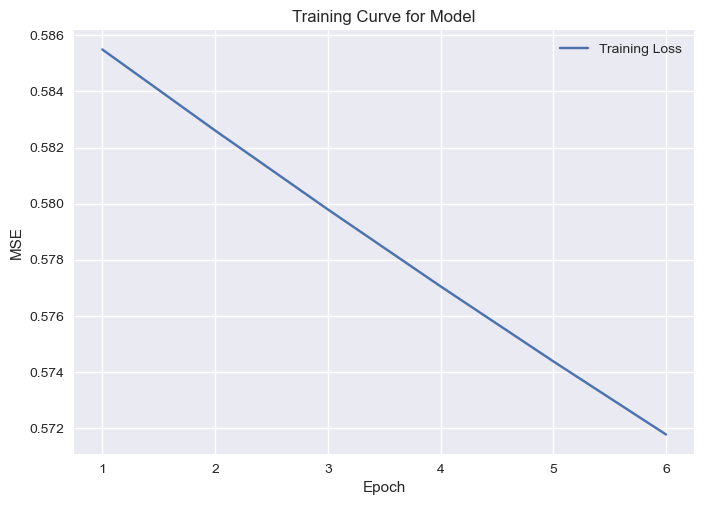

In [12]:
# Plot Training Curve
import matplotlib.pyplot as plt

train_step = np.arange(EPOCHS + 1) + 1

plt.style.use('seaborn')
plt.plot(train_step, train_loss, label = 'Training Loss')
#plt.plot(val_loss, label = 'Validation Loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('Training Curve for Model')
plt.legend()
plt.show()

In [ ]:
train_step = np.arange(EPOCHS) + 1

plt.style.use('seaborn')
plt.plot(train_step, train_gradients, label = 'Training Loss')
#plt.plot(val_loss, label = 'Validation Loss')
plt.ylabel('Average Gradient')
plt.xlabel('Epoch')
plt.title('Training Curve for Model')
plt.legend()
plt.show()